## Exercises of day 1
- Make a script for generating a test signal of length N for use in later exercises. 
    The test signal should contain two sinusoids with amplitudes 2 and 4 and  frequencies 
    500 and 2500 Hz, respectively, for a sampling frequency of 8 kHz, and WGN noise of variance 1.
- Implement the periodogram and correlogram spectral estimators and compare their PSD estimates 
    using the above test signal for different number of samples N.
- Show (with pen and paper) that a Fourier transform of a signal of length N can be broken into
    k smaller Fourier transforms of length N/k.
- Implement (in MATLAB/Python) the Bartlett and Welch methods.
- Implement a function for computing the down-sampled discrete-time analytic signal.
- Implement, in a function, the least squares method for AR parameter estimation. The starting 
    and end points should be selectable.
- Load the signal x in signal.mat and find the AR(2) parameters using the implemented least-squares
    method with starting and end points corresponding to the covariance method. Find also the variance 
    of the noise.
- Use the parameters of the AR model to estimate the PSD of the signal and compare the so-obtained 
    estimate to those of the correlogram and periodogram methods. What do you observe? 
- Plot the noise variance estimate as a function of the model order using the implemented estimator. 
    How can the model order be estimated?

In [1]:
# imports
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# parameters
A = [2, 4]
f = [500, 2500]
fs = 8000

Generate signal function

In [ ]:
def generate_signal(N, fs, A, f, plot=False):
    """
    Generate a complex test signal consisting of two sinusoids and complex white Gaussian noise.

    Parameters
    ----------
    N : int
        Length of the signal.
    fs : int or float
        Sampling frequency in Hz.
    A : array-like
        Amplitudes of the sinusoids.
    f : array-like
        Frequencies of the sinusoids in Hz.
    plot : bool, optional
        If True, plot the generated signal (default is False).

    Returns
    -------
    x : ndarray
        Generated complex signal of length N.
    """
    fs = 8000
    A = np.array(A)
    f = np.array(f)
    t = np.arange(N) / fs   # time vector in seconds
     
    x = np.sum(A[:, np.newaxis] * np.exp(1j * 2 * np.pi * f[:, np.newaxis] * t), axis=0)

    # Add complex Gaussian noise
    np.random.seed(42)
    noise = (np.random.normal(0, 1, N) +
            1j * np.random.normal(0, 1, N)) / np.sqrt(2)  # proper complex noise
    x = x + noise

    if plot:
        plt.figure(figsize=(10,4))
        plt.plot(t, x.real, label="Real part")
        plt.plot(t, x.imag, label="Imag part")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.title("Complex Signal (time domain)")
        plt.legend()
        plt.grid(True)

    return x

Defining the Correlogram and Periodogram

In [ ]:
def periodogram(x, fs, plot=False):
    """
    Estimate the Power Spectral Density (PSD) using the periodogram method.

    Parameters
    ----------
    x : array_like
        Input signal (1D array).
    fs : float
        Sampling frequency in Hz.
    plot : bool, optional
        If True, plot the estimated PSD (default is False).

    Returns
    -------
    Pxx : ndarray
        Estimated PSD values.
    """
    N = len(x)
    freqs = np.linspace(-fs/2, fs/2, N, endpoint=False)
    t = np.arange(N)/fs

    # DFT manually 
    X = np.zeros(N, dtype=complex)
    for k, f in enumerate(freqs):
        X[k] = np.sum(x * np.exp(-1j * 2 * np.pi * f * t))

    # Periodogram
    Pxx = (1/N) * np.abs(X)**2

    if plot:
        plt.figure(figsize=(7,1.5))
        plt.plot(freqs, Pxx.real, label="real")
        plt.plot(freqs, Pxx.imag, label="imaginary")
        plt.xlabel("Frequency")
        plt.ylabel("PSD")
        plt.title(f"Periodogram, N: {N}")
        plt.legend()
        plt.grid(True)
    return Pxx


def correlogram(x, fs, plot=False):
    """
    Estimate the Power Spectral Density (PSD) using the correlogram method.

    Parameters
    ----------
    x : array_like
        Input signal (1D array).
    fs : float
        Sampling frequency in Hz.
    plot : bool, optional
        If True, plot the estimated PSD (default is False).

    Returns
    -------
    Pxx : ndarray
        Estimated PSD values.
    """
    N = len(x)
    
    t = np.arange(N)/fs
    freqs = np.linspace(-fs/2, fs/2, N, endpoint=False)

    X = np.zeros(len(t), dtype=complex)

    ace = np.correlate(x,x, mode='full') / N
    ace = ace[N-1:]

    for i, f in enumerate(freqs):
        X[i] = np.sum(ace * np.exp(-1j * 2 * np.pi * f * t))

    # Correlogram
    Pxx = X.real

    if plot:
        plt.figure(figsize=(10,4))
        plt.plot(freqs, Pxx.real, label="real")
        plt.plot(freqs, Pxx.imag, label="imaginary")
        plt.xlabel("Frequency")
        plt.ylabel("PSD")
        plt.title(f"Correlogram, N: {N}")
        plt.legend()
        plt.grid(True)
    return Pxx

Generate signals for different Ns and calculate the periodogram and correlogram

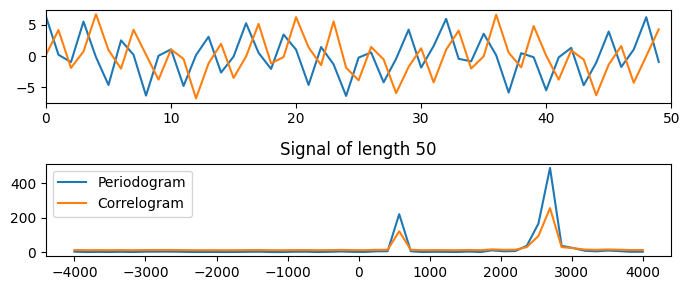

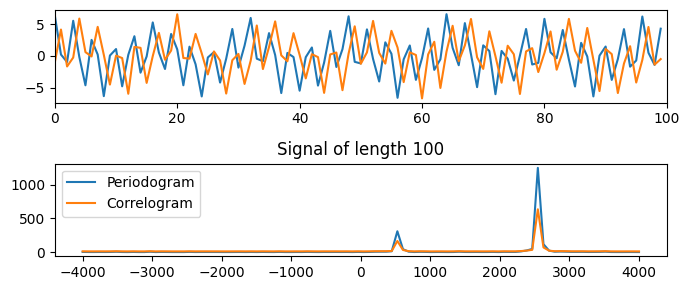

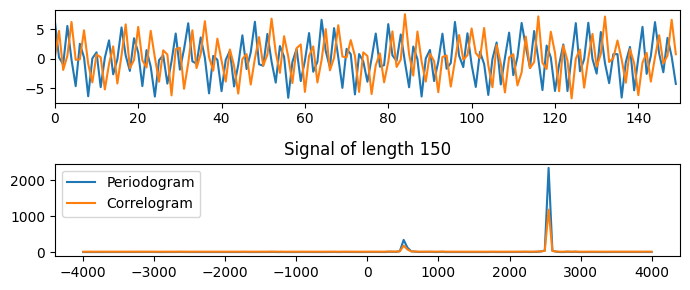

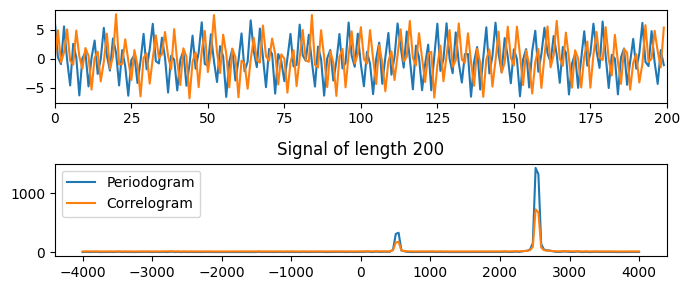

In [5]:
# Generate signals for different
for N in range(50, 250, 50):
    x = generate_signal(N, fs, A, f)
    Pxx_periodogram = periodogram(x, fs)
    Pxx_correlogram = correlogram(x, fs)

    fig, ax = plt.subplots(2,1, figsize=(7,3))
    plt.title(f'Signal of length {N}')
    ax[0].plot(np.arange(N), x.real, label='real')
    ax[0].plot(np.arange(N), x.imag, label='imaginary')
    ax[0].set_xlim(0, N)
    
    ax[1].plot(np.linspace(-fs/2, fs/2, N), Pxx_periodogram, label='Periodogram')
    ax[1].plot(np.linspace(-fs/2, fs/2, N), Pxx_correlogram, label='Correlogram')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

Defining the Bartlett and Welch methods

In [6]:
def bartlett(x, fs, L=10, plot=False):
    """
    Estimate the Power Spectral Density (PSD) using the Bartlett method.

    Parameters
    ----------
    x : array_like
        Input signal (1D array).
    fs : float
        Sampling frequency in Hz.
    L : int, optional
        Number of segments to divide the signal into (default is 10).
    plot : bool, optional
        If True, plot the estimated PSD (default is False).

    Returns
    -------
    pxx : ndarray
        Estimated PSD values.
    freqs : ndarray
        Frequency bins corresponding to the PSD values.
    """
    N = len(x)
    M = N // L  # Length of each segment
    x = x[:L * M]  # Truncate to fit segments
    segments = x.reshape(L, M)

    pxx = 0
    for seg in segments:
        pxx += periodogram(seg, fs)
    pxx /= L

    freqs = np.linspace(-fs/2, fs/2, M, endpoint=False)
    
    if plot:
        plt.plot(freqs, pxx, label=f"Bartlett PSD | L={L}")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("PSD")
        plt.legend()
        plt.grid(True)

    return pxx, freqs


def welch(x, fs, L=10, overlap=0.5, window=None, plot=False):
    """
    Estimate the Power Spectral Density (PSD) using the Welch method.

    Parameters
    ----------
    x : array_like
        Input signal (1D array).
    fs : float
        Sampling frequency in Hz.
    L : int, optional
        Number of segments to divide the signal into (default is 10).
    overlap : float, optional
        Fractional overlap between segments (0 <= overlap < 1, default is 0.5).
    window : ndarray or None, optional
        Window function to apply to each segment (default is Hann window).
    plot : bool, optional
        If True, plot the estimated PSD (default is False).

    Returns
    -------
    pxx : ndarray
        Estimated PSD values.
    freqs : ndarray
        Frequency bins corresponding to the PSD values.
    """
    N = len(x)

    if window is None:
        M = N // L
        window = np.hanning(M)
    elif isinstance(window, np.ndarray):
        M = len(window)
        print(f'Custom window set. Ignoring number of segments {L} and setting {N//M}')
        L = N // M 
    else:
        raise ValueError("window must be None or a numpy array")

    step = int(M * (1 - overlap))
    if step < 1:
        raise ValueError("Overlap too high, step size < 1")
    segments = []
    for start in range(0, N - M + 1, step):
        segments.append(x[start:start+M])
    segments = np.array(segments)
    
    pxx = 0
    for seg in segments:
        seg_win = seg * window
        pxx += periodogram(seg_win, fs)
    pxx /= len(segments)
    freqs = np.linspace(-fs/2, fs/2, M, endpoint=False)
    if plot:
        plt.plot(freqs, pxx, linestyle='--', label=f"Welch PSD | L={L}")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("PSD")
        plt.legend()
        plt.grid(True)
    return pxx, freqs

Using the Bartlett and Welch methods

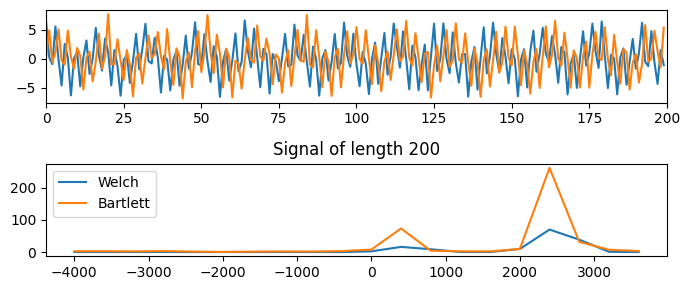

In [7]:
Pxx_bartlett, freqs_b = bartlett(x, fs, 10)
Pxx_welch, freqs_w = welch(x, fs, L=10)

fig, ax = plt.subplots(2,1, figsize=(7,3))
plt.title(f'Signal of length {N}')
ax[0].plot(np.arange(N), x.real, label='real')
ax[0].plot(np.arange(N), x.imag, label='imaginary')
ax[0].set_xlim(0, N)

ax[1].plot(freqs_w, Pxx_welch, label='Welch')
ax[1].plot(freqs_b, Pxx_bartlett, label='Bartlett')

plt.legend()
plt.tight_layout()
plt.show()

We now take a real signal and compute the discrete time analytical signal while downsampling

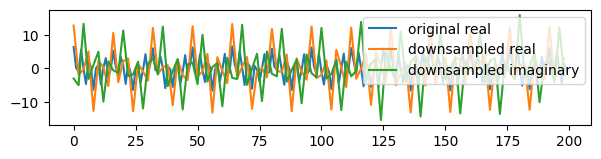

In [8]:
def ds_analytic(x, fs, plot=False):
    x_r = x.real
    N = len(x_r)

    X = np.fft.fft(x_r)

    H = np.zeros(N)
    if N % 2 == 0:  # even length
        H[0] = 1
        H[1:N//2] = 2
        H[N//2] = 1
    else:           # odd length
        H[0] = 1
        H[1:(N+1)//2] = 2
    
    X_a = X * H
    X_a = X_a[:np.ceil(N/2).astype(int)]
    x_a = np.fft.ifft(X_a)

    if plot:
        plt.plot(np.arange(N)/fs, x_r, label="real signal")
        plt.plot(np.arange(len(x_a))/fs * 2, x_a, label="analytical")
        plt.plot(np.arange(len(x_a))/fs * 2, x_a.imag, label="analytical_imag")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("PSD")
        plt.legend()
        plt.grid(True)

    return x_a

x = x.real

y = ds_analytic(x, fs)
plt.figure(figsize=(7,1.5))
plt.plot(np.arange(N), x.real, label='original real')
plt.plot(np.arange(N, step=2), y.real, label='downsampled real')
plt.plot(np.arange(N, step=2), y.imag, label='downsampled imaginary')
plt.legend()
plt.show()

Implementation of the least squares method

In [9]:
def least_squares(x, N1, N2, p, plot=False):
    def build_X():
        X = np.zeros((N2 - N1, p))
        for i, n in enumerate(range(N1, N2)):
            X[i, :] = x[n-1:n-p-1:-1]
        return X
    
    X =  build_X()
    pred_coeffs = - np.linalg.inv(X.T @ X) @ X.T @ x[N1:N2+1]

    # print('Predicted coefficients:', pred_coeffs)

    x_pred = np.zeros(N)
    for n in range(p, N):
        x_pred[n] = -np.dot(pred_coeffs, x[n-p:n][::-1])
    
    e = x - x_pred
    e_var = np.sqrt(np.var(e))
    # print('Noise variance: ', e_var)

    if plot:
        plt.figure(figsize=(7,1.5))
        plt.plot(np.arange(N), x, label='real')
        plt.plot(np.arange(N), x_pred, label='predicted')
        plt.title('Real vs. predicted signal') 
        plt.legend()   
    
    return pred_coeffs, x_pred, e_var

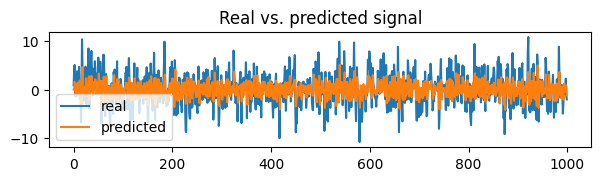

In [27]:
import scipy
# Load signal.mat
x = scipy.io.loadmat('signal.mat')['x']
x = x.reshape(1000)
N = len(x)
p = 2 

# N1, N2  of the covariance method
N1 = p + 1
N2 = N
prediction, x_pred, e_var = least_squares(x, N1, N2, p, True)
plt.show()



In [28]:
def param_psd(x_pred, e_var, plot=False):
    X = np.fft.fft(x_pred)
    freqs = np.fft.fftfreq(len(X))
    pxx = e_var**2 / (np.abs(X) ** 2)
    pxx = np.fft.fftshift(pxx)
    freqs = np.fft.fftshift(freqs)
    if plot:
        plt.figure(figsize=(7,1.5))
        plt.plot(freqs[:len(X)], pxx[:len(X)], label="Parametric PSD")
        plt.xlabel("Frequency")
        plt.ylabel("PSD")
        plt.legend()
        plt.grid(True)
    
    return pxx

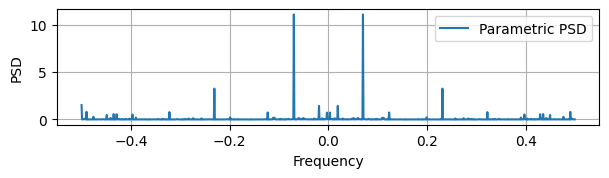

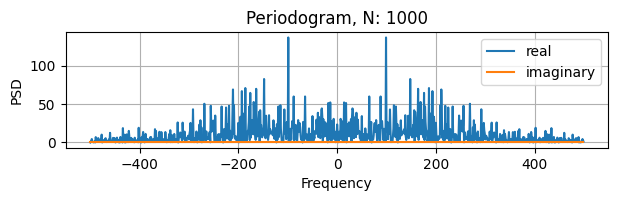

In [29]:
param_psd(x_pred, e_var, True)
plt.show()
periodogram(x, N, plot=True)
plt.show()

Regarding the two PSDs, we observe that the periodogram has high variance compared to the parametric approach. On the other hand, the parametric approach has two clearly defined sharp peaks, matching the model order.

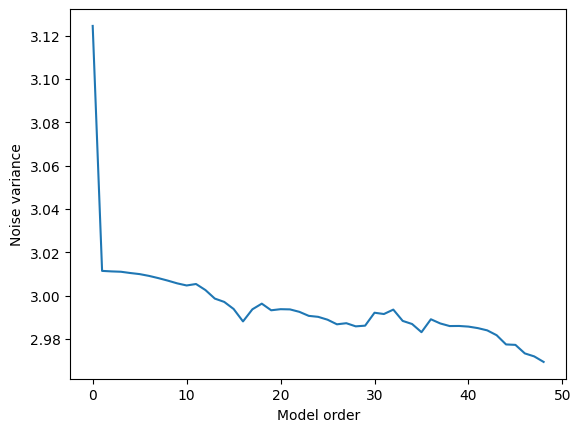

In [23]:
e_var_list = []
for p in range(1, 50):
    N1 = p + 1
    N2 = N
    _, _, e_var = least_squares(x,N1, N2, p, False)
    e_var_list.append(e_var)

plt.plot(range(len(e_var_list)), e_var_list)
plt.xlabel('Model order')
plt.ylabel('Noise variance')
plt.show()

We observe a sharp drop in the noise variance that corresponds to the model order.